## Simulation RL agents in variant Two Step task
Jianning Chen @ Neural Computation Unit, OIST

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import seaborn as sns
from filterpy import monte_carlo
from numpy.random import randn
import scipy.stats as ss
import multiprocess as mp
import seaborn as sns
import random
import heapq
import time
from statistics import variance
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW


Action: 0 for right, 1 for left

State: 0 for down state, 1 for up

Trans_state: 1 for A (left commonly to up), 0 for B (right commonly to down state)

In [5]:
class Exp_mov_ave:
    # Exponential moving average class.
    def __init__(self, tau, init_value=0):
        self.tau = tau
        self.init_value = init_value
        self.reset()

    def reset(self, init_value=None, tau=None):
        if tau:
            self.tau = tau
        if init_value:
            self.init_value = init_value
        self.value = self.init_value
        self._m = math.exp(-1.0 / self.tau)
        self._i = 1 - self._m

    def update(self, sample):
        self.value = (self.value * self._m) + (self._i * sample)


In [6]:
def show_behavior(result):
    fig, ax = plt.subplots(figsize = (16,8))
    ax.plot(result[:,12],'b')
    ax.plot(result[:,1],'.k', label = 'Reward Status')
    ax.plot(result[:,4],'-g')
    ax.plot(result[:,5],'.-.r', label = "Action value (Right)")
    ax.plot(result[:,6],'.-.y', label = "Action value (Left)")
    ax.set_ylabel('Exponential Moving Average (Left)',fontsize = 20)
    ax.set_xlabel('# trials', fontsize = 20)
    ax.yaxis.label.set_color('blue')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20,frameon=False)
    ax2 = ax.twinx()
    ax2.set_ylabel('Reward probability (Left)', fontsize = 20)
    ax2.yaxis.label.set_color('green')

In [7]:
def get_table(model, data, N):
    para_time = {key:np.zeros((len(data),N)) for key in model.para}
    for i in range(len(data)):
        for j in range(len(data[i])):
            for z, key in enumerate(model.para):
                para_time[key][i,j] = data[i][j][z]
    return para_time

In [8]:
# define the two step task
class two_step:
    def __init__(self, trans = "A", reward = 1, nstate = 2,naction = 2, allow_blocks = ['up', 'down', 'neutral']):
        """define the environment and probability"""
        self.trans = trans
        self.trans_prob = np.zeros((naction,nstate))
        self.reward_prob = np.zeros((nstate,1))
        self.allow_blocks = allow_blocks
        # transition matrix = [[right-down, right-up], [left-down, left-up]]
        if self.trans == "A":
            self.trans_prob = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.trans_prob = np.array([[0.2,0.8],[0.8,0.2]])
        self.block = None
        
    def set_block(self,block_type):
        # reward probability matrix = [[down-noreward, down-reward], [up-noreward, up-reward]]
        self.block = block_type
        if self.block == "up":
            self.reward_prob = np.array([[0.8,0.2],[0.2,0.8]])
        elif self.block == "down":
            self.reward_prob = np.array([[0.2,0.8],[0.8,0.2]])
        elif self.block == "neutral":
            self.reward_prob = np.array([[0.5,0.5],[0.5,0.5]])
    def step(self, action):
        state = np.random.multinomial(1,self.trans_prob[action]).tolist().index(1)
        # 0 is down, 1 is up
        reward = np.random.multinomial(1,self.reward_prob[state]).tolist().index(1)
        return(state, reward)


In [9]:
class RL_lambda0:
    def __init__(self, nstate = 2, naction = 2):
        """Initialize the agent with default parameters"""
        self.alpha1 = 0.1 # learning rate for experienced state and action
        self.beta = 0.1
        self.Qmf = np.zeros((naction,1)) # 0:right, 1:left
        self.V = np.zeros((nstate,1))  # 0 for down and 1 for up
        self.parameter = {'alpha1', 'beta'}
    def boltzmann(self, q):
        """Boltzmann selection"""
        p = np.exp(self.beta * q)
        p = p/sum(p)    # probability
        # sample by multinoulli (categorical) distribution
        s = np.random.multinomial(1,p.ravel())
        return list(s).index(1)  # find the index of 1

    def choice(self):
        action = self.boltzmann(self.Qmf)
        return(action)
    
    def learn(self, action, reward, state):
        """Update the state and action value"""
        self.V[state] = (1 - self.alpha1) * self.V[state] + self.alpha1 * reward
        
        # update the action value for model-free agent
        # for chosen action
        self.Qmf[action] = (1 - self.alpha1) * self.Qmf[action] + self.alpha1 * reward


In [10]:
class RL_lambda:
    def __init__(self, nstate = 2, naction = 2):
        """Initialize the agent with default parameters"""
        self.alpha1 = 0.1 # learning rate for experienced state and action
        self.beta = 0.1
        self.lam = 0.1
        self.Qmf = np.zeros((naction,1)) # 0:right, 1:left
        self.V = np.zeros((nstate,1))  # 0 for down and 1 for up
        self.parameter = {'alpha1', 'beta'}
    def boltzmann(self, q):
        """Boltzmann selection"""
        p = np.exp(self.beta * q)
        p = p/sum(p)    # probability
        # sample by multinoulli (categorical) distribution
        s = np.random.multinomial(1,p.ravel())
        return list(s).index(1)  # find the index of 1

    def choice(self):
        action = self.boltzmann(self.Qmf)
        return(action)
    
    def learn(self, action, reward, state):
        """Update the state and action value"""
        self.V[state] = (1 - self.alpha1) * self.V[state] + self.alpha1 * reward
        
        # update the action value for model-free agent
        # for chosen action
        self.Qmf[action] = (1 - self.alpha1) * self.Qmf[action] + \
            self.alpha1 * self.lam * reward + (1 - self.lam) * self.V[state]


In [11]:
class RL_hybird:
    def __init__(self, nstate = 2, naction = 2, trans = 'A'):
        """Initialize the agent with default parameters"""
        self.alpha1 = 0.1 # learning rate for experienced state and action
        self.beta = 0.1
        self.epsilon = 0.5
        self.Qmf = np.zeros((naction,1)) # 0:right, 1:left
        self.Qmb = np.zeros((naction,1)) # 0:right, 1:left
        self.Qnet = np.zeros((naction,1)) # 0:right, 1:left
        self.V = np.zeros((nstate,1))  # 0 for down and 1 for up
        self.parameter = {'alpha1', 'beta', 'epsilon'}
        self.trans_prob = []
    def boltzmann(self, q):
        """Boltzmann selection"""
        p = np.exp(self.beta * q)
        p = p/sum(p)    # probability
        # sample by multinoulli (categorical) distribution
        s = np.random.multinomial(1,p.ravel())
        return list(s).index(1)  # find the index of 1

    def choice(self):
        action = self.boltzmann(self.Qnet)
        return(action)
    
    def learn(self, action, reward, state, trans):
        """Update the state and action value"""
        # transition matrix = [[right-down, right-up], [left-down, left-up]]
        if trans == "A":
            self.trans_prob = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.trans_prob = np.array([[0.2,0.8],[0.8,0.2]])
        self.block = None
        self.V[state] = (1 - self.alpha1) * self.V[state] + self.alpha1 * reward
        
        # update the action value for model-free agent
        # for chosen action
        self.Qmf[action] = (1 - self.alpha1) * self.Qmf[action] + \
            self.alpha1 * reward
            
        self.Qmb[0] = self.V[0] * self.trans_prob[0][0] + self.V[1] * self.trans_prob[0][1]
        self.Qmb[1] = self.V[0] * self.trans_prob[1][0] + self.V[1] * self.trans_prob[1][1]
        
        self.Qnet[0] = self.epsilon * self.Qmf[0] + (1 - self.epsilon) * self.Qmb[0]
        self.Qnet[1] = self.epsilon * self.Qmf[1] + (1 - self.epsilon) * self.Qmb[1]


In [13]:
class interaction:
    def __init__(self, env, agent, nstate, naction, thres = 0.75, trans = "A", reward = 1):
        self.env = env(trans, reward, nstate, naction)
        self.agent = agent(nstate, naction)
        self.thres = thres
        self.init_set = random.sample(self.env.allow_blocks, k=len(self.env.allow_blocks)).copy()
        self.t_till_reversal = 0
        self.MovAve = Exp_mov_ave(tau = 8, init_value=0.5)
        self.cross_thres = False
        self.first_block = True
    
    def parameter_ready(self, nBlock, nPerTrial, nTrial, para_input):
        """prepare the parameter list for simulation"""
        para_list = dict(zip(self.agent.parameter, [[],[], []]))
        # check if all parameters are specified in para_input
        if para_input.keys() != para_list.keys():
            raise Exception('All parameters should be specified')
        exp_len = nTrial if nPerTrial == None else nBlock * nPerTrial
        for i in para_list:
            if i in para_input:
                if np.size(para_input[i]) == exp_len:
                    para_list[i] = para_input[i]
                else:
                    para_list[i] = np.repeat(para_input[i], exp_len)
        return para_list
    
    def block_sampler(self):
        block = self.init_set.pop(0)
        self.env.set_block(block)
        if len(self.init_set) == 1:
            self.init_set.extend(random.sample([i for i in self.env.allow_blocks if i != self.init_set[0]], k = 1).copy())
            self.init_set.extend(random.sample([i for i in self.env.allow_blocks if i != self.init_set[-1]], k = len(self.env.allow_blocks) -1).copy())

    def block_transition_depend(self):
        """transit the block based on current moving average of the performance (non-neutral blocks) 
        or the number of blocks"""
        if self.first_block: # if it is the first block
            self.block_sampler() # do block sample
            self.first_block = False
            if self.env.block == 'neutral': # if the first one is neutral block, then start countdown
                self.cross_thres = True # allow for countdown
                self.t_till_reversal = np.random.randint(20, 30) # random the remaining trials
        else: # if not the first block
            if (not self.cross_thres) & (self.MovAve.value > self.thres): # if threshold has not been passed and it should 
                self.cross_thres = True # marked as passed
                self.t_till_reversal = np.random.randint(5, 15) # generate the remaining trials 

            if (self.cross_thres) & (self.t_till_reversal <= 0): # if threshold passed and ready for reversal
                self.block_sampler() # block change
                self.MovAve.reset()
                if self.env.block == 'neutral': # if new block is neutral
                    self.cross_thres = True # 
                    self.t_till_reversal = np.random.randint(20, 30) # generate the fixed period for neutral blocks
                else:
                    self.cross_thres = False 
            
    def update_Mov_ave(self, action):
        if (self.env.block == 'up') & (self.env.trans == 'A'):
            self.MovAve.update(np.double(action == 1))
        elif (self.env.block == 'down') & (self.env.trans == 'A'):
            self.MovAve.update(np.double(action == 0))
        if (self.env.block == 'up') & (self.env.trans == 'B'):
            self.MovAve.update(np.double(action == 0))
        elif (self.env.block == 'down') & (self.env.trans == 'B'):
            self.MovAve.update(np.double(action == 1))
        
    def run(self, para_input, nBlock = None, nPerTrial = None, nTrial = 100):
        """Run the two step task, nBlocks is specified when certain number of blocks is desired.
        nPerTrial is specified when the block change happened after certain number of trial. 
        nTrial is specified when totally a certain number of trial is simulated."""
        # prepare the empty matrix for recording
        Trsa = np.zeros((nTrial, 18))
        # get the the parameter setting ready for simulation
        para_list = self.parameter_ready(nBlock, nPerTrial, nTrial, para_input)
        # initialize the trial-dependent measure
        for t in range(nTrial): # loop all trial
            # setup the block transition mechanism
            if nPerTrial == None:
                self.block_transition_depend()
            elif t % nPerTrial == 0:
                self.block_sampler()
            if t == 0:
                self.agent.beta = para_list['beta'][0]
                self.agent.alpha1 = para_list['alpha1'][0]
                self.agent.epsilon = para_list['epsilon'][0]
                action = self.agent.choice() # choice
            state, reward = self.env.step(action) # interaction with the environment
            self.update_Mov_ave(action)
                
            self.MovAve.update(reward)
            self.t_till_reversal -= 1
            # get the reward probability commonly leaded by the left choice (1)
            trans_ = np.argmax(self.env.trans_prob[1])
            prob = self.env.reward_prob[trans_][1]
            Trsa[t,:] = [t, reward, state, action, prob, np.double(self.agent.Qnet[0]), 
                         np.double(self.agent.Qnet[1]), np.double(self.agent.Qmf[0]), 
                         np.double(self.agent.Qmf[1]), np.double(self.agent.Qmb[0]), 
                         np.double(self.agent.Qmb[1]),np.double(self.agent.V[0]), np.double(self.agent.V[1]),
                         self.agent.alpha1, self.agent.beta, self.agent.epsilon, np.double(self.env.trans == 'A'), self.MovAve.value]
            
            if t < nTrial -1:
                self.agent.alpha1 = para_list['alpha1'][1 + t]; 
                self.agent.beta = para_list['beta'][1 + t];
                self.agent.epsilon = para_list['epsilon'][1 + t];
                self.agent.learn(action, reward, state, self.env.trans)
                action = self.agent.choice()
                
        return(Trsa[:nTrial, :])

In [14]:
class filter_lambda0: # consider next ten trials
    def __init__(self, data, estimate = 'gaussian', variable = {"alpha1": 0.01, "beta": 0.01},init_dist = {"QR":[0,1],"QL":[0,1], "Vdown":[0,1], "Vup":[0,1], "alpha1":[0,1], "beta":[0,2]}, nstep = 10):
        """define the basic structure of filter class"""
        self.N = 10 # default number of particles
        self.data = data
        self.para = list(init_dist.keys())
        self.n_para = len(self.para)
        self.para_dist = init_dist
        self.particles = [];
        self.variable = variable
        self.filename = "ID_" + str(int(data['ID'].unique()[0]))
        self.AveMove = [];
        self.bandwidth = 0.05
        self.nstep = nstep # how many trials in the future will be considered for fitting
        self.estimate = estimate
        self.nstep = nstep
    def init_particles(self):
        """The function initialize the prior distribution for estimated parameters"""
        particles_ = []
        for i in range(self.n_para):
            particles_.append(list(np.random.uniform(self.para_dist[self.para[i]][0], self.para_dist[self.para[i]][1], self.N)))
            
        self.particles = np.reshape(particles_, (self.n_para, self.N)).T    
        self.step = np.ones((self.N,2))

    def learn(self, choice, state, reward, trans_state):
        """Learning the past experience by updating the state and action value based on last trial events"""
        # check the internal model
        if trans_state == 1:
            self.P = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.P = np.array([[0.2,0.8],[0.8,0.2]])
            
        # update the state and state value
        for i in range(self.N):
            if state == 0: # if down state is reached
                state_value = self.particles[i][2]
            elif state == 1: # if up state is reached
                state_value = self.particles[i][3]
            
            # Updating the action/ state values, QR: particles[i][0]; QL: particles[i][1]
            if choice == 0: # if choose right
                self.particles[i][0] = (1 - self.particles[i][4]) * self.particles[i][0] + \
                    self.particles[i][4] * reward
                        
            elif choice == 1: # if choose left
                self.particles[i][1] = (1 - self.particles[i][4]) * self.particles[i][1] + \
                    self.particles[i][4] * reward

            # updating the state values,  Vup: particles[i][2], Vdown: particles[i][3]
            if state == 0: # if down state is reached
                self.particles[i][2] = (1 - self.particles[i][4]) * self.particles[i][2] + self.particles[i][4] * reward
            elif state == 1: # if up state is reached
                self.particles[i][3] = (1 - self.particles[i][4]) * self.particles[i][3] + self.particles[i][4] * reward             

    def choose(self, trans_state):
        """Make the choice based on the learned value"""
        self.predict = []
        self.predict_sum = []
        # check if the block type change
        if trans_state == 1:
            self.P = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.P = np.array([[0.2,0.8],[0.8,0.2]])
        for i in range(self.N):
            # Blotzmann selection
            p = np.exp(self.particles[i][5] * self.particles[i][1])/(np.exp(self.particles[i][5] * self.particles[i][1]) + np.exp(self.particles[i][5] * self.particles[i][0]))
            self.predict.append(np.double(p)) # store the prediction value 
        self.predict_sum = np.mean(self.predict)
        
        
    def weighting(self, choice):
        """according to the actual choice, for each particles, its importance weight is 
            given as its predicted probability"""
        if choice == 0: # if the choice is right
            self.predict = [1 - self.predict[i] for i in range(len(self.predict))]
            self.predict_sum = 1 - self.predict_sum
        self.predict = self.predict/sum(self.predict) # weighted likelihood
        
    def ReLU_weight(self, threshold):
        """An activation function that kills the particles that lower than certain level"""
        self.predict[self.predict < threshold] = 0
        self.predict = self.predict/sum(self.predict)
        
    def dropout(self, percentage):
        self.predict[np.argpartition(self.predict, int(percentage * self.N))[:int(percentage*self.N)]] = 0
        self.predict = self.predict/sum(self.predict)
        
    def non_gaussian_resample(self, method = 'systematic'):
        """ the weighted importance is then replaced by unweighted measure, and particles are resampled"""
        if method == 'systematic':
            off_list = monte_carlo.systematic_resample(self.predict)
        elif method == 'stratified':
            off_list = monte_carlo.stratified_resample(self.predict)
        elif method == 'residual':
            off_list = monte_carlo.residual_resample(self.predict)
            
        new_particle = []
        for i in range(len(off_list)):
            new_particle.append(self.particles[off_list[i]].tolist())
        self.particles = np.array(new_particle)
    
    def gaussian_kde_resample(self):
        ReParticle = []   
        kde = ss.gaussian_kde(dataset=self.particles.T, weights = self.predict) # * np.sqrt(np.power(self.step[:,0],2) + np.power(self.step[:,1],2)))
        kde.set_bandwidth(kde.factor *0.01)# * (1 - self.predict_sum) * 0.01)
        ReParticle = kde.resample(self.N)
        ReParticle[4, (ReParticle[4] > 1)] = 1
        ReParticle[4, (ReParticle[4] < 0)] = 0
        ReParticle[5, (ReParticle[5] < 0)] = 0
        self.particles = ReParticle.T
        

    def select_estimate(self):
        """select the estimate method. Allowed methods are: gaussian, n-step forward method, and clustered"""
        
        assert self.estimate in ('gaussian', 'forward', 'clustered'), 'invalid estimate method'
        
        
    def update_para(self, para = 'All'):
        """for each particle, the action value and meta-parameters are updated according to transition rule"""
        # update the action value
        para = self.para if para == "All" else para
        for i in range(len(self.particles)):
            # updating other parameters
            if "alpha1" in para:
                self.step[i,0] = np.random.normal(0, self.variable['alpha1'])
                self.particles[i][4] += self.step[i,0]
                if self.particles[i][4] < 0:
                    self.particles[i][4] = 0
                elif self.particles[i][4] > 1:
                    self.particles[i][4] = 1
            if "beta" in para:
                self.step[i,1] = np.random.normal(0, self.variable['beta'])
                self.particles[i][5] += self.step[i,1]
                if self.particles[i][5] < 0:
                    self.particles[i][5] = 0

        
    def gaussian_estimate (self):
        """run particle filter estimate based on one-step multivariate gaussian resampling"""
        # make space for store the result
        prediction = [] # store the prediction
        particles = [] # store the particles dist.
        i = 0 # start from trial 0
        # run estimate
        while i <= len(self.data) -1: # take each step
            if self.data.trial_type.iloc[i] == 2: # if it was free choice trial
                # for the initial condition, only choose step is involved but not the learning step
                if i == 0:
                    self.choose(self.data.trans_state.iloc[i]) # make the first choice
                else:
                    self.learn(choice,state, reward, trans_state)
                    self.choose(trans_state)
                self.weighting(self.data.choice.iloc[i])
                self.gaussian_kde_resample()
                prediction.append(self.predict_sum)
                particles.append(self.particles)
                self.update_para()
            else:
                if i != 0:
                    self.learn(choice, state, reward, trans_state)
            
            choice, state, reward, trans_state = self.data.choice.iloc[i], self.data.second_state.iloc[i], self.data.outcome.iloc[i], self.data.trans_state[i]
            i += 1
        return(prediction, particles)

    def forward_estimate(self, alpha_var = 'Default', beta_var = 'Default', nstep = 3, N_particle = 1000):
        """run particle filter estimate based on N-step multivariate gaussian resampling"""
        
        self.variable['alpha1'] = alpha_var
        self.variable['beta'] = beta_var
        self.nstep = nstep
        self.N = N_particle
        
        self.init_particles()
        
        # make space for store the result
        prediction = [] # store the prediction
        particles = [] # store the particles dist.
        alpha_est = []
        beta_est = []
        predict_var = []
        predict_mean = []
        i = 0 # start from trial 0
        # run estimate
        while i <= len(self.data) -1: # take each step
            if self.data.trial_type.iloc[i] == 2: # if it was free choice trial
                # for the initial condition, only choose step is involved but not the learning step
                if i == 0:
                    self.choose(self.data.trans_state.iloc[i]) # make the first choice
                else:
                    self.learn(choice,state, reward, trans_state)
                    self.choose(self.data.trans_state.iloc[i])
                # begin the N-step forward prediction
                # store the current particles
                prior_particle = self.particles
                acc_predict = np.zeros([self.N, self.nstep + 1])
                self.weighting(self.data.choice.iloc[i])
                acc_predict[:,0] = self.predict # store the predict for the first time
                for t in range(self.nstep): # for each step in the future
                    if i + self.nstep >= len(self.data) -1:
                        break
                    if self.data.trial_type.iloc[i+t] == 2:
                        # learn from the previous step
                        self.learn(self.data.choice.iloc[i+t-1], self.data.second_state.iloc[i+t-1], self.data.outcome.iloc[i+t-1], self.data.trans_state.iloc[i+t-1])
                        self.choose(self.data.trans_state.iloc[i + t])
                        self.weighting(self.data.choice.iloc[i+t])
                        acc_predict[:,t+1] = self.predict # store the predictions
                self.predict = np.array(acc_predict.mean(axis = 1).tolist()) # take the average prediction NOTE: normalized it
                self.weighting(1)
                self.particles = prior_particle
                alpha_est.append(self.particles[np.argmax(self.predict)][4])
                beta_est.append(self.particles[np.argmax(self.predict)][5])
                predict_var.append(variance(self.predict))
                predict_mean.append(np.mean(self.predict))
                #self.ReLU_weight(1/self.N)
                self.non_gaussian_resample(method = self.estimate)
                # self.gaussian_kde_resample()
                prediction.append(self.predict_sum)
                particles.append(self.particles)
                self.update_para()
            else:
                if i != 0:
                    self.learn(choice, state, reward, trans_state)
            
            choice, state, reward, trans_state = self.data.choice.iloc[i], self.data.second_state.iloc[i], self.data.outcome.iloc[i], self.data.trans_state[i]
            i += 1
        return self.variable, self.nstep, self.N, prediction, particles, alpha_est, beta_est, predict_var, predict_mean


In [15]:
class filter_hybird: # consider next ten trials
    def __init__(self, data, estimate = 'gaussian', variable = {"alpha1": 0.01, "beta": 0.01, 'epsilon': 0.01},init_dist = {"QR":[0,1],"QL":[0,1], "QR_mf":[0,1],"QL_mf":[0,1],"QR_mb":[0,1],"QL_mb":[0,1],"Vdown":[0,1], "Vup":[0,1], "alpha1":[0,1], "beta":[0,2], 'epsilon':[0,1]}, nstep = 10):
        """define the basic structure of filter class"""
        self.N = 10 # default number of particles
        self.data = data
        self.para = list(init_dist.keys())
        self.n_para = len(self.para)
        self.para_dist = init_dist
        self.particles = [];
        self.variable = variable
        self.filename = "ID_" + str(int(data['ID'].unique()[0]))
        self.AveMove = []
        self.nstep = nstep # how many trials in the future will be considered for fitting
        self.estimate = estimate

    def init_particles(self):
        """The function initialize the prior distribution for estimated parameters"""
        particles_ = []
        for i in range(self.n_para):
            particles_.append(list(np.random.uniform(self.para_dist[self.para[i]][0], self.para_dist[self.para[i]][1], self.N)))
            
        self.particles = np.reshape(particles_, (self.n_para, self.N)).T    
        self.step = np.ones((self.N,3))

    def learn(self, choice, state, reward, trans_state):
        """Learning the past experience by updating the state and action value based on last trial events"""
        # check the internal model
        if trans_state == 1:
            self.P = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.P = np.array([[0.2,0.8],[0.8,0.2]])
            
        # update the state and state value
        for i in range(self.N):
            # Updating the action/ state values, QR: particles[i][0]; QL: particles[i][1]
            if choice == 0: # if choose right
                self.particles[i][2] = (1 - self.particles[i][8]) * self.particles[i][2] + \
                    self.particles[i][8] * reward
                        
            elif choice == 1: # if choose left
                self.particles[i][3] = (1 - self.particles[i][8]) * self.particles[i][3] + \
                    self.particles[i][8] * reward

            # updating the state values,  Vup: particles[i][2], Vdown: particles[i][3]
            if state == 0: # if down state is reached
                self.particles[i][6] = (1 - self.particles[i][8]) * self.particles[i][6] + self.particles[i][8] * reward
            elif state == 1: # if up state is reached
                self.particles[i][7] = (1 - self.particles[i][8]) * self.particles[i][7] + self.particles[i][8] * reward             
        # check if the block type change transition matrix = [[right-down, right-up], [left-down, left-up]]
            if trans_state == 1:
                self.P = np.array([[0.8,0.2],[0.2,0.8]])
            else:
                self.P = np.array([[0.2,0.8],[0.8,0.2]])
            self.particles[i][4] = self.P[0][0] * self.particles[i][6] + self.P[0][1] * self.particles[i][7]
            self.particles[i][5] = self.P[1][0] * self.particles[i][6] + self.P[1][1] * self.particles[i][7]
            self.particles[i][0] = self.particles[i][10] * self.particles[i][2] + (1 - self.particles[i][10]) * self.particles[i][4]
            self.particles[i][1] = self.particles[i][10] * self.particles[i][3] + (1 - self.particles[i][10]) * self.particles[i][5]
    def choose(self, trans_state):
        """Make the choice based on the learned value"""
        self.predict = []
        self.predict_sum = []
        # check if the block type change
        if trans_state == 1:
            self.P = np.array([[0.8,0.2],[0.2,0.8]])
        else:
            self.P = np.array([[0.2,0.8],[0.8,0.2]])
        for i in range(self.N):
            # Blotzmann selection
            p = np.exp(self.particles[i][9] * self.particles[i][1])/(np.exp(self.particles[i][9] * self.particles[i][1]) + np.exp(self.particles[i][9] * self.particles[i][0]))
            self.predict.append(np.double(p)) # store the prediction value 
        self.predict_sum = np.mean(self.predict)
        
        
    def weighting(self, choice):
        """according to the actual choice, for each particles, its importance weight is 
            given as its predicted probability"""
        if choice == 0: # if the choice is right
            self.predict = [1 - self.predict[i] for i in range(len(self.predict))]
            self.predict_sum = 1 - self.predict_sum
        #self.predict = np.log(self.predict)
        self.predict = self.predict/sum(self.predict) # weighted likelihood
        
    def ReLU_weight(self, threshold):
        """An activation function that kills the particles that lower than certain level"""
        self.predict[self.predict < threshold] = 0
        self.predict = self.predict/sum(self.predict)
        
    def dropout(self, percentage):
        self.predict[np.argpartition(self.predict, int(percentage * self.N))[:int(percentage*self.N)]] = 0
        self.predict = self.predict/sum(self.predict)
        
    def non_gaussian_resample(self, method = 'systematic'):
        """ the weighted importance is then replaced by unweighted measure, and particles are resampled"""
        if method == 'systematic':
            off_list = monte_carlo.systematic_resample(self.predict)
        elif method == 'stratified':
            off_list = monte_carlo.stratified_resample(self.predict)
        elif method == 'residual':
            off_list = monte_carlo.residual_resample(self.predict)
            
        new_particle = []
        for i in range(len(off_list)):
            new_particle.append(self.particles[off_list[i]].tolist())
        self.particles = np.array(new_particle)
    
    def gaussian_kde_resample(self):
        ReParticle = []   
        kde = ss.gaussian_kde(dataset=self.particles.T, weights = self.predict) # * np.sqrt(np.power(self.step[:,0],2) + np.power(self.step[:,1],2)))
        kde.set_bandwidth(kde.factor *0.01)# * (1 - self.predict_sum) * 0.01)
        ReParticle = kde.resample(self.N)
        ReParticle[4, (ReParticle[4] > 1)] = 1
        ReParticle[4, (ReParticle[4] < 0)] = 0
        ReParticle[5, (ReParticle[5] < 0)] = 0
        self.particles = ReParticle.T
        

    def select_estimate(self):
        """select the estimate method. Allowed methods are: gaussian, n-step forward method, and clustered"""
        
        assert self.estimate in ('gaussian', 'forward', 'clustered'), 'invalid estimate method'
        
        
    def update_para(self, para = 'All'):
        """for each particle, the action value and meta-parameters are updated according to transition rule"""
        # update the action value
        para = self.para if para == "All" else para
        for i in range(len(self.particles)):
            # updating other parameters
            if "alpha1" in para:
                self.step[i,0] = np.random.normal(0, self.variable['alpha1'])
                self.particles[i][8] += self.step[i,0]
                if self.particles[i][8] < 0:
                    self.particles[i][8] = 0
                elif self.particles[i][8] > 1:
                    self.particles[i][8] = 1
            if "beta" in para:
                self.step[i,1] = np.random.normal(0, self.variable['beta'])
                self.particles[i][9] += self.step[i,1]
                if self.particles[i][9] < 0:
                    self.particles[i][9] = 0
            if "epsilon" in para:
                self.step[i,2] = np.random.normal(0, self.variable['epsilon'])
                self.particles[i][10] += self.step[i,2]
                if self.particles[i][10] < 0:
                    self.particles[i][10] = 0
                elif self.particles[i][10] > 1:
                    self.particles[i][10] = 1

    def forward_estimate(self, alpha_var = 'Default', beta_var = 'Default', epsilon_var = 'Default', nstep = 3, N_particle = 1000):
        """run particle filter estimate based on N-step multivariate gaussian resampling"""
        
        self.variable['alpha1'] = alpha_var
        self.variable['beta'] = beta_var
        self.variable['epsilon'] = epsilon_var
        self.nstep = nstep
        self.N = N_particle
        
        self.init_particles()
        
        # make space for store the result
        prediction = [] # store the prediction
        # particles = [] # store the particles dist.
        predict_mean = []
        predict_std = []
        SSE = []
        i = 0 # start from trial 0
        # run estimate
        while i <= len(self.data) -1: # take each step
            if self.data.trial_type.iloc[i] == 2: # if it was free choice trial
                # for the initial condition, only choose step is involved but not the learning step
                if i == 0:
                    self.choose(self.data.trans_state.iloc[i]) # make the first choice
                else:
                    self.learn(choice,state, reward, trans_state)
                    self.choose(self.data.trans_state.iloc[i])
                # begin the N-step forward prediction
                # store the current particles
                prior_particle = self.particles
                acc_predict = np.zeros([self.N, self.nstep + 1])
                self.weighting(self.data.choice.iloc[i])
                acc_predict[:,0] = self.predict # store the predict for the first time
                for t in range(self.nstep): # for each step in the future
                    if i + self.nstep >= len(self.data) -1:
                        break
                    if self.data.trial_type.iloc[i+t] == 2:
                        # learn from the previous step
                        self.learn(self.data.choice.iloc[i+t-1], self.data.second_state.iloc[i+t-1], self.data.outcome.iloc[i+t-1], self.data.trans_state.iloc[i+t-1])
                        self.choose(self.data.trans_state.iloc[i + t])
                        self.weighting(self.data.choice.iloc[i+t])
                        acc_predict[:,t+1] = self.predict # store the predictions
                self.predict = np.array(acc_predict.mean(axis = 1).tolist()) # take the average prediction NOTE: normalized it
                self.weighting(1)
                self.particles = prior_particle
                result_ = DescrStatsW(self.particles, weights = self.predict)
                predict_mean.append(result_.mean)
                predict_std.append(result_.std)
                SSE.append([np.square(result_.mean[8] - self.data.alpha1.iloc[i]), np.square(result_.mean[9] - self.data.beta.iloc[i]), np.square(result_.mean[10] - self.data.epsilon.iloc[i])])
                # self.ReLU_weight(1/self.N)
                # self.dropout(0.01)

                self.non_gaussian_resample(method = self.estimate)
                # self.gaussian_kde_resample()
                prediction.append(self.predict_sum)
                # particles.append(self.particles)
                self.update_para()
            else:
                if i != 0:
                    self.learn(choice, state, reward, trans_state)
            
            choice, state, reward, trans_state = self.data.choice.iloc[i], self.data.second_state.iloc[i], self.data.outcome.iloc[i], self.data.trans_state[i]
            i += 1
        
        return self.variable, self.nstep, self.N, prediction, predict_mean, predict_std, SSE
  

In [1607]:
alpha1_list = [0.3]; beta_list = [2]; epsilon_list = [0.5];

alpha1_noise = 0.03; beta_noise = 0.03; epsilon_noise = 0.03;
Ntrial = 2100

In [1608]:
for i in range(Ntrial-1):
    alpha1_list.append(np.clip((alpha1_list[-1] + np.random.normal(0, alpha1_noise)), 0,1))
    beta_list.append(np.clip((beta_list[-1] + np.random.normal(0, beta_noise)), 0, None))
    epsilon_list.append(np.clip((epsilon_list[-1] + np.random.normal(0, epsilon_noise)), 0,1))

Text(0, 0.5, 'Inverse Temperature')

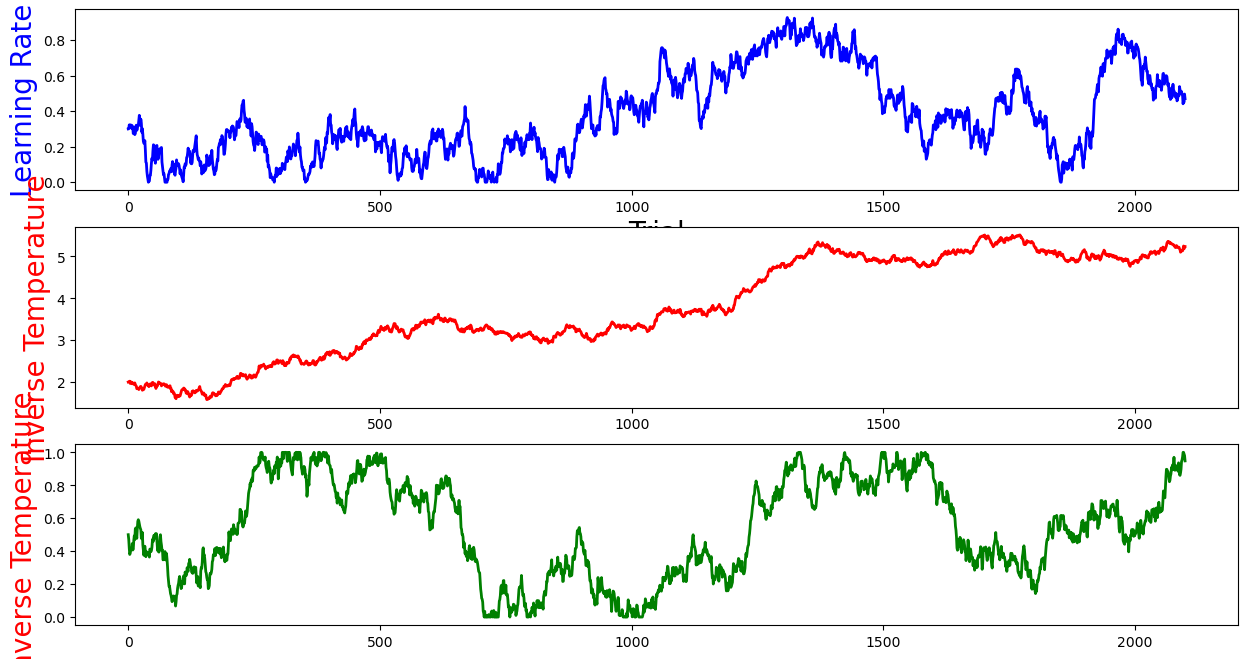

In [1609]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(311)
ax1.plot(alpha1_list, color = 'b', linewidth = 2)
ax1.set_ylabel('Learning Rate',color = 'b', fontsize = 20)
ax1.set_xlabel('Trial', fontsize = 20)
ax2 = fig.add_subplot(312)
ax2.plot(beta_list, color = 'r', linewidth = 2)
ax2.set_ylabel('Inverse Temperature',color = 'r',fontsize = 20)
ax3 = fig.add_subplot(313)
ax3.plot(epsilon_list, color = 'g', linewidth = 2)
ax3.set_ylabel('Inverse Temperature',color = 'r',fontsize = 20)

In [1617]:
sim1 = interaction(two_step, RL_hybird,2,2)

In [1618]:
result1 = sim1.run(para_input={'alpha1':alpha1_list, 'beta':beta_list, 'epsilon':epsilon_list}, nTrial=Ntrial)

In [1619]:
A = pd.DataFrame(result1,columns=["time", "outcome", "second_state", "choice", "prob", "QR", "QL", "QR_MB", "QL_MB", "QR_MB", "QL_MB", "Vdown", "Vup", 'alpha1', 'beta', 'epsilon', 'trans_state', 'MovAve'])
A['ID'] = '1'
A['trial_type'] = 2
print(A)

        time  outcome  second_state  choice  prob        QR        QL  \
0        0.0      0.0           0.0     0.0   0.5  0.000000  0.000000   
1        1.0      0.0           1.0     1.0   0.5  0.000000  0.000000   
2        2.0      1.0           0.0     1.0   0.5  0.000000  0.000000   
3        3.0      0.0           1.0     1.0   0.5  0.152977  0.155387   
4        4.0      1.0           1.0     1.0   0.5  0.150577  0.119029   
...      ...      ...           ...     ...   ...       ...       ...   
2095  2095.0      1.0           1.0     0.0   0.5  0.237271  0.070027   
2096  2096.0      1.0           0.0     0.0   0.5  0.585138  0.070027   
2097  2097.0      1.0           1.0     0.0   0.5  0.771271  0.074314   
2098  2098.0      0.0           0.0     0.0   0.5  0.881884  0.083287   
2099  2099.0      1.0           0.0     0.0   0.5  0.468032  0.101551   

         QR_MB     QL_MB     QR_MB     QL_MB     Vdown       Vup    alpha1  \
0     0.000000  0.000000  0.000000  0.000000 

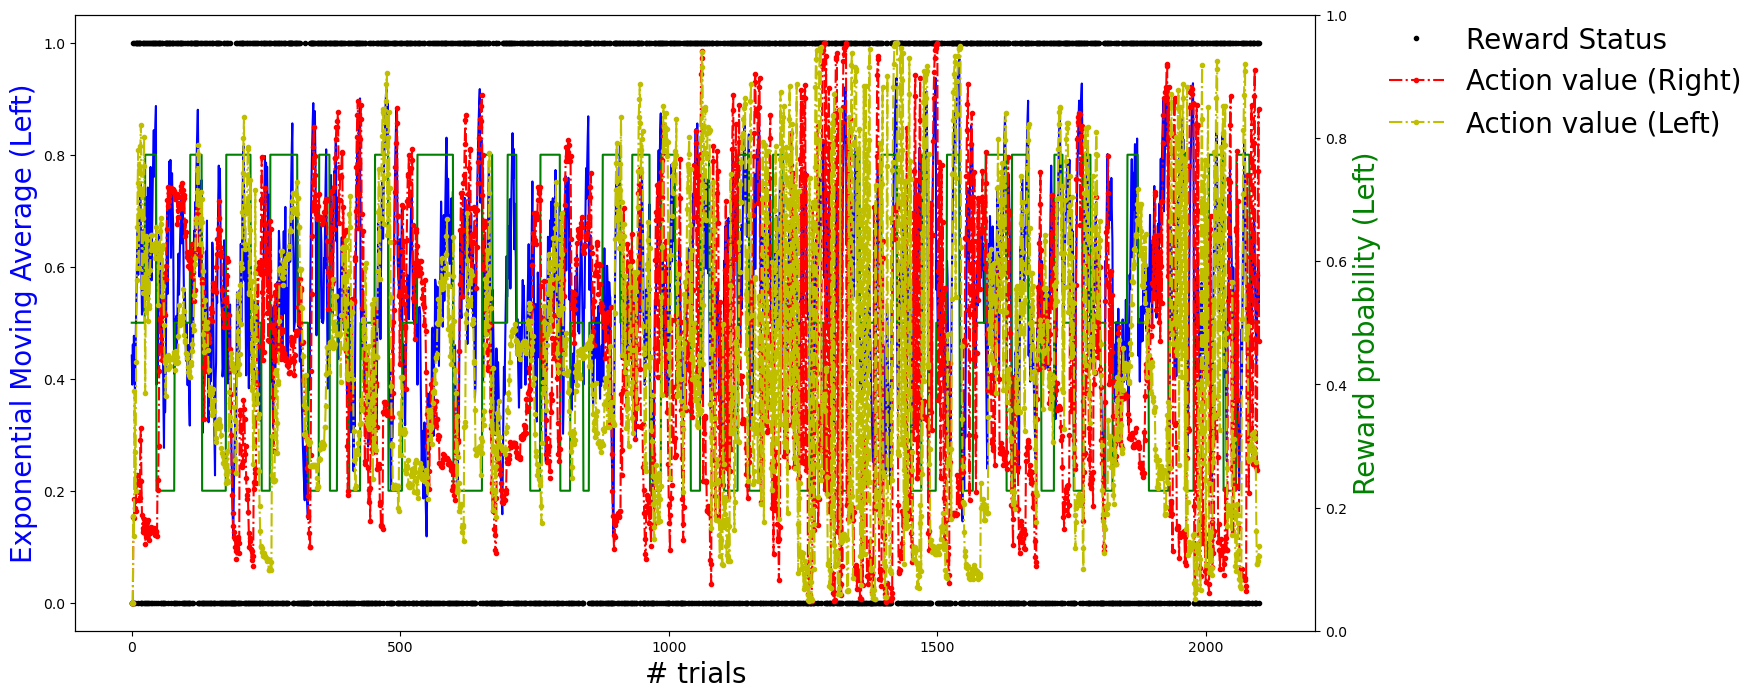

In [1620]:
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(A['MovAve'],'b')
ax.plot(A['outcome'],'.k', label = 'Reward Status')
ax.plot(A['prob'],'-g')
ax.plot(A['QR'],'.-.r', label = "Action value (Right)")
ax.plot(A['QL'],'.-.y', label = "Action value (Left)")
ax.set_ylabel('Exponential Moving Average (Left)',fontsize = 20)
ax.set_xlabel('# trials', fontsize = 20)
ax.yaxis.label.set_color('blue')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=20,frameon=False)
ax2 = ax.twinx()
ax2.set_ylabel('Reward probability (Left)', fontsize = 20)
ax2.yaxis.label.set_color('green')

Text(0, 0.5, 'MB-MF tradeoff')

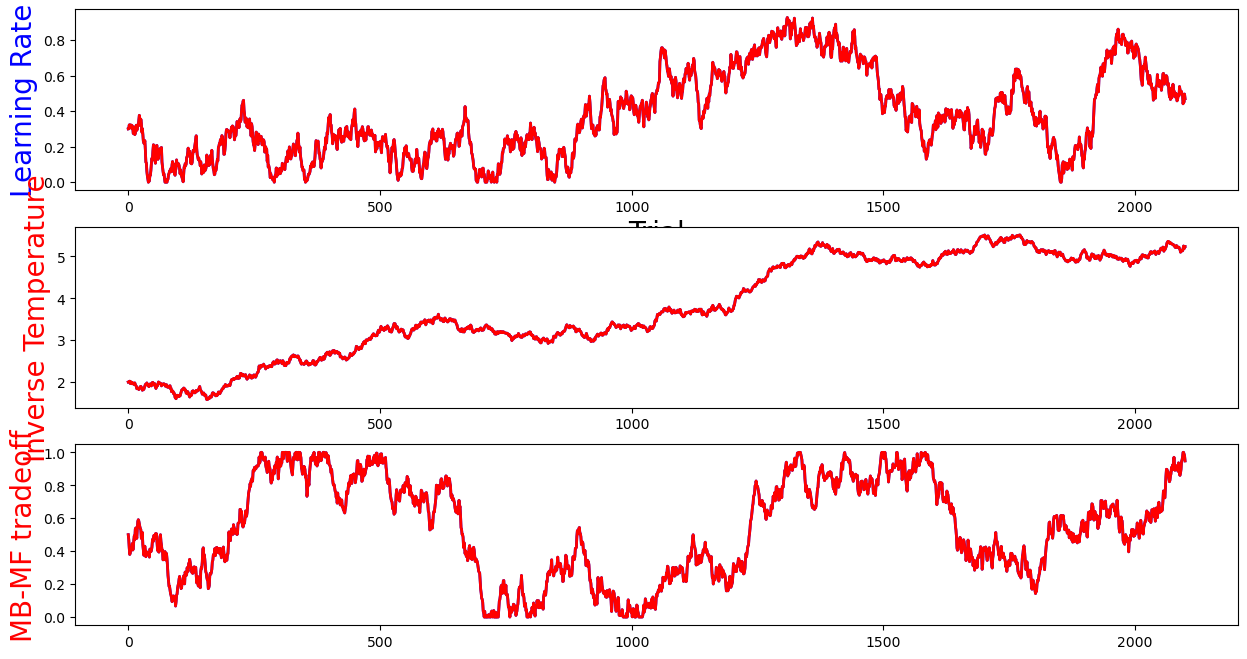

In [1621]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(311)
ax1.plot(alpha1_list, color = 'b', linewidth = 2)
ax1.plot(A['alpha1'], color = 'r', linewidth = 2)
ax1.set_ylabel('Learning Rate',color = 'b', fontsize = 20)
ax1.set_xlabel('Trial', fontsize = 20)
ax2 = fig.add_subplot(312)
ax2.plot(beta_list, color = 'b', linewidth = 2)
ax2.plot(A['beta'], color = 'r', linewidth = 2)
ax2.set_ylabel('Inverse Temperature',color = 'r',fontsize = 20)
ax3 = fig.add_subplot(313)
ax3.plot(epsilon_list, color = 'b', linewidth = 2)
ax3.plot(A['epsilon'], color = 'r', linewidth = 2)
ax3.set_ylabel('MB-MF tradeoff',color = 'r',fontsize = 20)

In [1622]:
'alpha' + str(alpha1_noise) + 'beta' + str(beta_noise) + 'epsilon' + str(epsilon_noise)

'alpha0.03beta0.03epsilon0.03'

In [1616]:
A.to_csv('/Users/chenjianning/Library/CloudStorage/OneDrive-OIST/PhD materials/thesis_study/Particle_filter/HPC_code/recover/' + 'alpha' + str(alpha1_noise) + '_beta' + str(beta_noise) + '_epsilon' + str(epsilon_noise) + '/1st/' + 'data.csv')

In [1623]:
A.to_csv('/Users/chenjianning/Library/CloudStorage/OneDrive-OIST/PhD materials/thesis_study/Particle_filter/HPC_code/recover/' + 'alpha' + str(alpha1_noise) + '_beta' + str(beta_noise) + '_epsilon' + str(epsilon_noise) + '/2nd/' + 'data.csv')

## Variables in each Particles

* [0]: action value (right)
* [1]: action value (left)
* [2]: state value (down)
* [3]: state value (up)
* [4]: learning rate
* [5]: Inverse temperature
###

## Variables in each Particles

* [0]: net action value (right)
* [1]: net action value (left)
* [2]: MF action value (right)
* [3]: MF action value (left)
* [4]: MB action value (right)
* [5]: MB action value (left)
* [6]: state value (down)
* [7]: state value (up)
* [8]: learning rate
* [9]: Inverse temperature
* [10]: MB MF trade off

In [1029]:
para_list = []
for i in range(5):
    for j in range(5):
        for e in range(5):
            for z in range(4):
                para_list.append((0.007 + i* 0.001, 0.007 + j*0.001,  0.007 + j*0.001, 1 + z,1000))

In [1030]:
f1 = filter_hybird(A,estimate = 'stratified', init_dist = {"QR":[0,0],"QL":[0,0], "Vdown":[0,0], "Vup":[0,0], "alpha1":[0,1], "beta":[0,2]})

In [1031]:
if __name__ == "__main__":
    with mp.Pool() as pool:
        result = pool.starmap(f1.forward_estimate, para_list)
    print("finished")

IndexError: index 9 is out of bounds for axis 0 with size 6

In [ ]:
para_list = []
for i in range(5):
    for j in range(5):
        for e in range(5):
            for z in range(4):
                para_list.append((0.017 + i* 0.001, 0.027 + j*0.001, 1 + z,1000))

In [215]:
alldata = {'filename':{}, 'MaxLikehood':np.zeros((len(para_list),1)), 'parameter':{}, 'n_step':{}, 'n_particle':{}, 'result':{}, 'beta_true':np.zeros((len(para_list),1)),'beta_est':np.zeros((len(para_list),1)),'alpha_true':np.zeros((len(para_list),1)),'alpha_est':np.zeros((len(para_list),1)), 'SSE':np.zeros((len(para_list),1))}

for i in range(len(para_list)):

    para_time = get_table(f1, result[i][4], result[i][2])
    alldata['filename'][i] = i
    alldata['MaxLikehood'][i] = np.mean(result[i][3])
    alldata['parameter'][i] = result[i][0]
    alldata['n_step'][i] = result[i][1]
    alldata['n_particle'][i] = result[i][2]
    alldata['result'][i] = para_time
    alldata['SSE_alpha1'][i] = mean_squared_error(np.mean(para_time['alpha1'], axis=1), np.array(A['alpha1']))
    alldata['SSE_beta'][i] = mean_squared_error(np.mean(para_time['beta'], axis=1), np.array(A['beta']))
    alldata['SSE_epsilon'][i] = mean_squared_error(np.mean(para_time['epsilon'], axis=1), np.array(A['epsilon']))

KeyError: 'SSE_alpha1'

In [265]:
mean_squared_error(np.mean(para_time['alpha1'], axis=1), np.array(A['alpha1']))

0.017149712576073416

In [201]:
np.mean(para_time['alpha1'], axis=1)

array([0.51094827, 0.51673414, 0.50425259, ..., 0.26998067, 0.27978772,
       0.28983268])

In [632]:
Pre_result = pd.DataFrame()
Pre_result = pd.DataFrame(alldata['parameter']).T
Pre_result['SSE'] = alldata['SSE'].flatten()
Pre_result['step'] = pd.Series(alldata['n_step']).tolist()
Pre_result['MaxLikelihood'] = alldata['MaxLikehood'].flatten()

<Axes: xlabel='step', ylabel='SSE'>

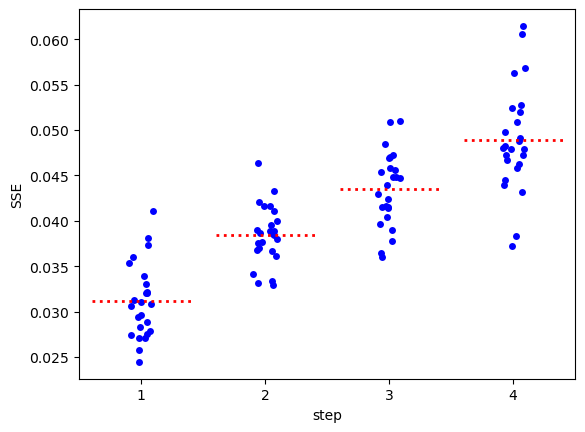

In [633]:
sns.stripplot(x = 'step', y = 'SSE', data = Pre_result, jitter= True, color = 'b')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'r', 'ls': ':', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x = 'step', y = 'SSE',
            data=Pre_result,
            showfliers=False,
            showbox=False,
            showcaps=False)

Text(0, 0.5, 'MaxLikelihood')

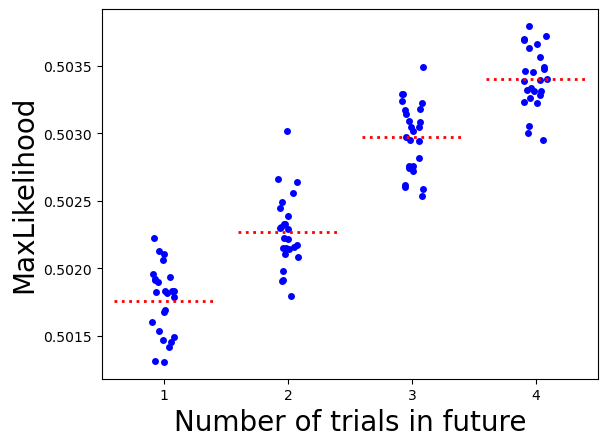

In [634]:
sns.stripplot(x = 'step', y = 'MaxLikelihood', data = Pre_result, jitter= True, color = 'b')
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'r', 'ls': ':', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x = 'step', y = 'MaxLikelihood',
            data=Pre_result,
            showfliers=False,
            showbox=False,
            showcaps=False)
plt.xlabel('Number of trials in future', fontsize = 20)
plt.ylabel('MaxLikelihood', fontsize = 20)

In [635]:
for i in range(len(alldata['result'])):
    if alldata['MaxLikehood'][i] == alldata['MaxLikehood'].max():
        print(i)
        min_index = i

11


In [636]:
for i in range(len(alldata['result'])):
    if alldata['SSE'][i] == alldata['SSE'].min():
        print(i)
        min_index = i

4


In [637]:
min_index
para_time = alldata['result'][min_index]
lens = A.__len__()
print(alldata['MaxLikehood'][min_index], alldata['SSE'][min_index], alldata['parameter'][min_index], alldata['n_step'][min_index], alldata['n_particle'][min_index])

[0.5018188] [0.02444675] {'alpha1': 0.017, 'beta': 0.028} 1 1000


/var/folders/1b/gc6hjt1x3hzgg14fv0vw46nh0000gn/T/ipykernel_91674/3945334584.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,1,1)


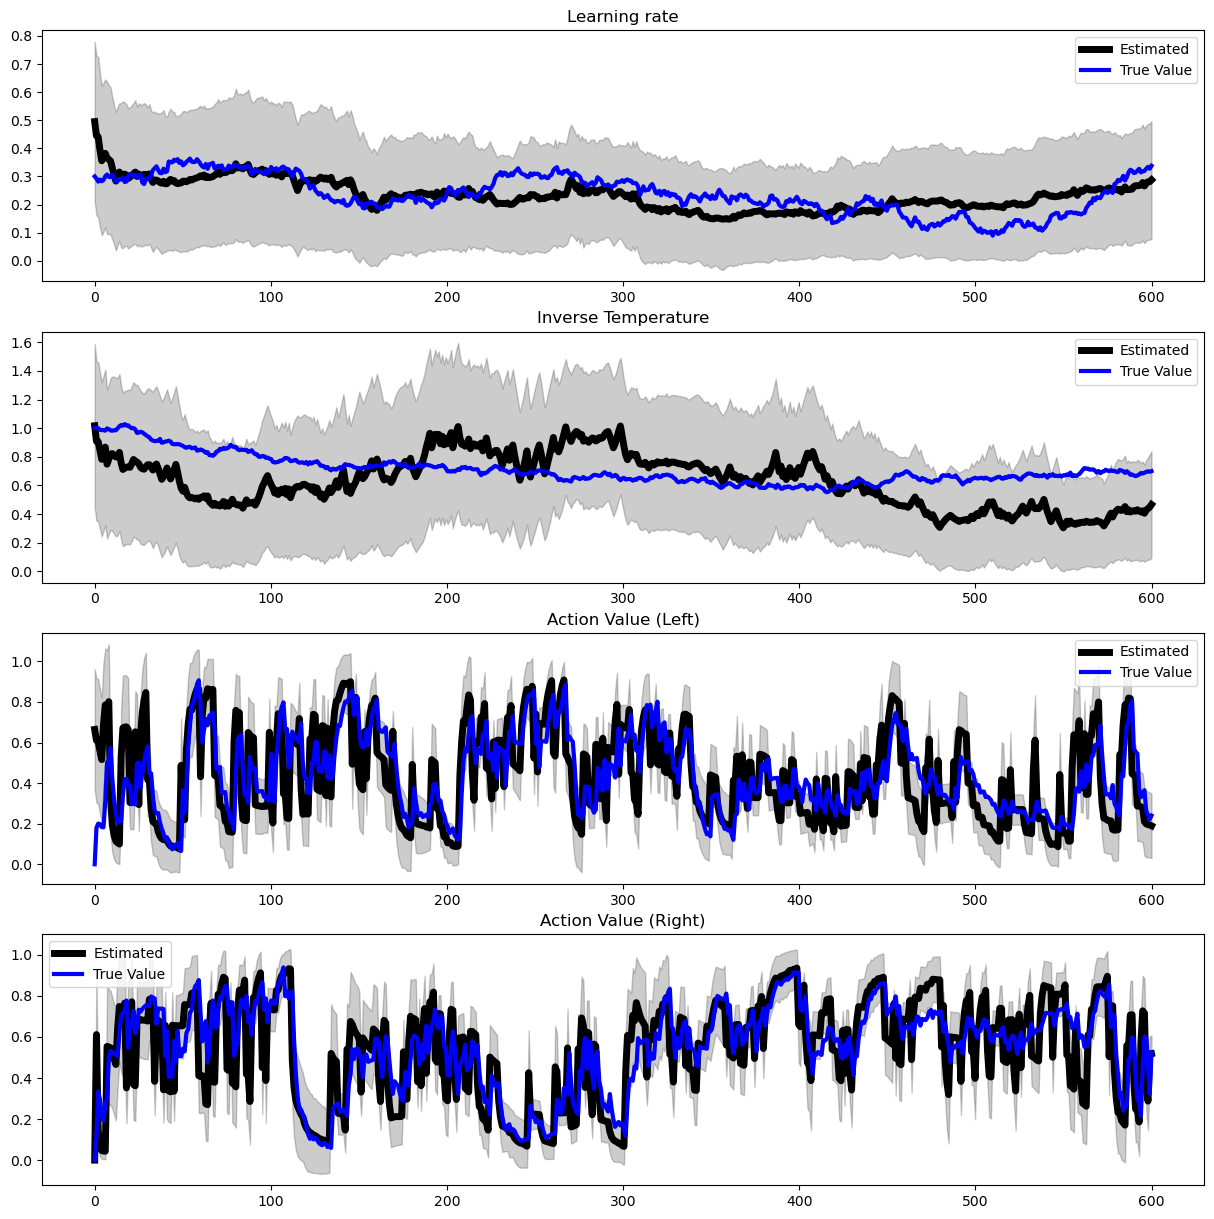

In [638]:
plt.subplots(figsize = (15,15))
plt.subplot(4,1,1)
mean_ = pd.DataFrame(para_time['alpha1']).mean(1)
std_ = np.nanstd(para_time['alpha1'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['alpha1'], 'b',  linewidth = 3, label="True Value")
plt.title('Learning rate')
plt.legend()

plt.subplot(4,1,2)
mean_ = pd.DataFrame(para_time['beta']).mean(1)
std_ = np.nanstd(para_time['beta'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['beta'], 'b',  linewidth = 3, label="True Value")
plt.title('Inverse Temperature')
plt.legend()

plt.subplot(4,1,3)
mean_ = pd.DataFrame(para_time['QL']).mean(1)
std_ = np.nanstd(para_time['QL'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QL'], 'b', linewidth = 3, label="True Value")
plt.title('Action Value (Left)')
plt.legend()

plt.subplot(4,1,4)
mean_ = pd.DataFrame(para_time['QR']).mean(1)
std_ = np.nanstd(para_time['QR'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QR'], 'b', linewidth = 3, label="True Value")
plt.title('Action Value (Right)')
plt.legend()


In [2218]:
para_list = []
for i in range(2):
    for j in range(2):
        for e in range(2):
            for z in range(1):
                para_list.append((0.03 + i* 0.001, 0.03 + j*0.001,  0.03 + e*0.001, 3 + z,10))

In [2219]:
para_list

[(0.03, 0.03, 0.03, 3, 10),
 (0.03, 0.03, 0.031, 3, 10),
 (0.03, 0.031, 0.03, 3, 10),
 (0.03, 0.031, 0.031, 3, 10),
 (0.031, 0.03, 0.03, 3, 10),
 (0.031, 0.03, 0.031, 3, 10),
 (0.031, 0.031, 0.03, 3, 10),
 (0.031, 0.031, 0.031, 3, 10)]

In [2220]:
f1 = filter_hybird(A,estimate = 'stratified',init_dist = {"QR":[0,0],"QL":[0,0], "QR_mf":[0,0],"QL_mf":[0,0],"QR_mb":[0,0],"QL_mb":[0,0],"Vdown":[0,0], "Vup":[0,0], "alpha1":[0,1], "beta":[0,2], 'epsilon':[0,1]})


In [2221]:
if __name__ == "__main__":
    with mp.Pool() as pool:
        result = pool.starmap(f1.forward_estimate, para_list)
    print("finished")

finished


In [2230]:
alldata = {'filename':{}, 'MaxLikehood':np.zeros((len(para_list),1)), 'parameter':{}, 'n_step':{}, 'n_particle':{}, 'result_mean':{}, 'result_std': {}, 'SSE':{}}

maxlikelihood = 0
max_index = 0
for i in range(len(para_list)):
    alldata['filename'][i] = i
    alldata['MaxLikehood'][i] = np.mean(result[i][3])
    alldata['parameter'][i] = result[i][0]
    alldata['n_step'][i] = result[i][1]
    alldata['n_particle'][i] = result[i][2]
    alldata['result_mean'][i] = result[i][4]
    alldata['result_std'][i] = result[i][5]
    alldata['SSE'][i] = result[i][6]


In [2233]:
alldata['SSE'][0]

[[0.004105794450051322, 0.01727670816880906, 0.00029005730395821936],
 [0.03154653817169613, 0.0004689642019117202, 0.00097891985334088],
 [0.028421892913922418, 0.00014398686009897154, 0.003227542242585081],
 [0.014336196556219559, 0.00022896431700709862, 0.0041696029228152805],
 [0.02489188700428285, 0.003094416650276921, 0.001053438891236234],
 [0.01682824703288736, 0.0013257788707619878, 1.5232761788443862e-08],
 [0.044534530254206305, 0.03950846260320364, 0.00010389371820466309],
 [0.0445530256088821, 0.006643277763690396, 4.3171895707652116e-05],
 [0.032447110485572216, 2.1716373885352695e-05, 0.0006404793043039201],
 [0.06273625249179977, 0.009046214279443797, 0.0027497027527943457],
 [0.027862689470189873, 0.007113630406865216, 0.0014979416788180272],
 [0.050106064681867776, 0.006293957806623944, 0.006205950791638813],
 [0.09137392424493962, 0.006025997175495807, 0.004169239190571376],
 [0.05255807930483415, 0.006418224364835731, 0.002281032440928177],
 [0.04526117505371464, 0.

In [2228]:
np.shape(result[0][6])

(2100, 3)

In [2196]:
alldata['MaxLikehood'].argmax()

7

In [222]:
path = '/Users/chenjianning/Library/CloudStorage/OneDrive-OIST/PhD materials/thesis_study/Particle_filter/result/recover/Alpha0.01_beta0.01_epsilon0.01/1st/result.pkl'
with open(path, 'rb') as f:
            alldata = pickle.load(f)

In [242]:
path = '/Users/chenjianning/Library/CloudStorage/OneDrive-OIST/PhD materials/thesis_study/Particle_filter/result/recover/Alpha0.01_beta0.01_epsilon0.01/1st/data.csv'
A = pd.read_csv(path)
A = A.head(600)

In [2187]:
lens = 2100

/var/folders/1b/gc6hjt1x3hzgg14fv0vw46nh0000gn/T/ipykernel_912/3427942387.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,1,1)


IndexError: index 9 is out of bounds for axis 1 with size 3

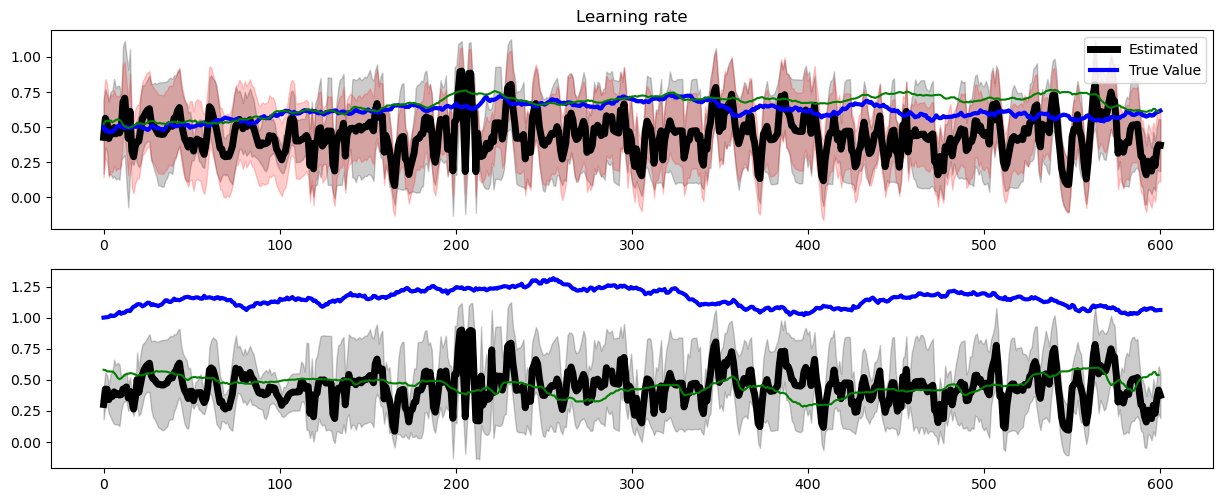

In [411]:
plt.subplots(figsize = (15,15))
plt.subplot(5,1,1)
mean_ = pd.DataFrame(para_time['alpha1']).mean(1)
std_ = np.nanstd(para_time['alpha1'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['alpha1'], 'b',  linewidth = 3, label="True Value")
plt.plot(np.squeeze(result[0][4])[:,8], c = 'g')
std_ = np.squeeze(result[0][5])[:,8]
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.title('Learning rate')
plt.legend()

plt.subplot(5,1,2)
mean_ = pd.DataFrame(para_time['beta']).mean(1)
std_ = np.nanstd(para_time['beta'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['beta'], 'b',  linewidth = 3, label="True Value")
plt.plot(np.squeeze(result[0][5])[:,9], c = 'g')
std_ = np.squeeze(result[0][6])[:,9]
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.title('Inverse Temperature')
plt.legend()

plt.subplot(5,1,3)
mean_ = pd.DataFrame(para_time['epsilon']).mean(1)
std_ = np.nanstd(para_time['epsilon'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['epsilon'], 'b',  linewidth = 3, label="True Value")
plt.title('Inverse Temperature')
plt.legend()

plt.subplot(5,1,4)
mean_ = pd.DataFrame(para_time['QL']).mean(1)
std_ = np.nanstd(para_time['QL'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QL'], 'b', linewidth = 3, label="True Value")
plt.title('Action Value (Left)')
plt.legend()

plt.subplot(5,1,5)
mean_ = pd.DataFrame(para_time['QR']).mean(1)
std_ = np.nanstd(para_time['QR'],axis=1)
plt.plot(np.linspace(0,lens,lens),mean_, 'k', linewidth = 5, label = "Estimated")
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'k', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QR'], 'b', linewidth = 3, label="True Value")
plt.title('Action Value (Right)')
plt.legend()


/var/folders/1b/gc6hjt1x3hzgg14fv0vw46nh0000gn/T/ipykernel_912/310005959.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,1,1)


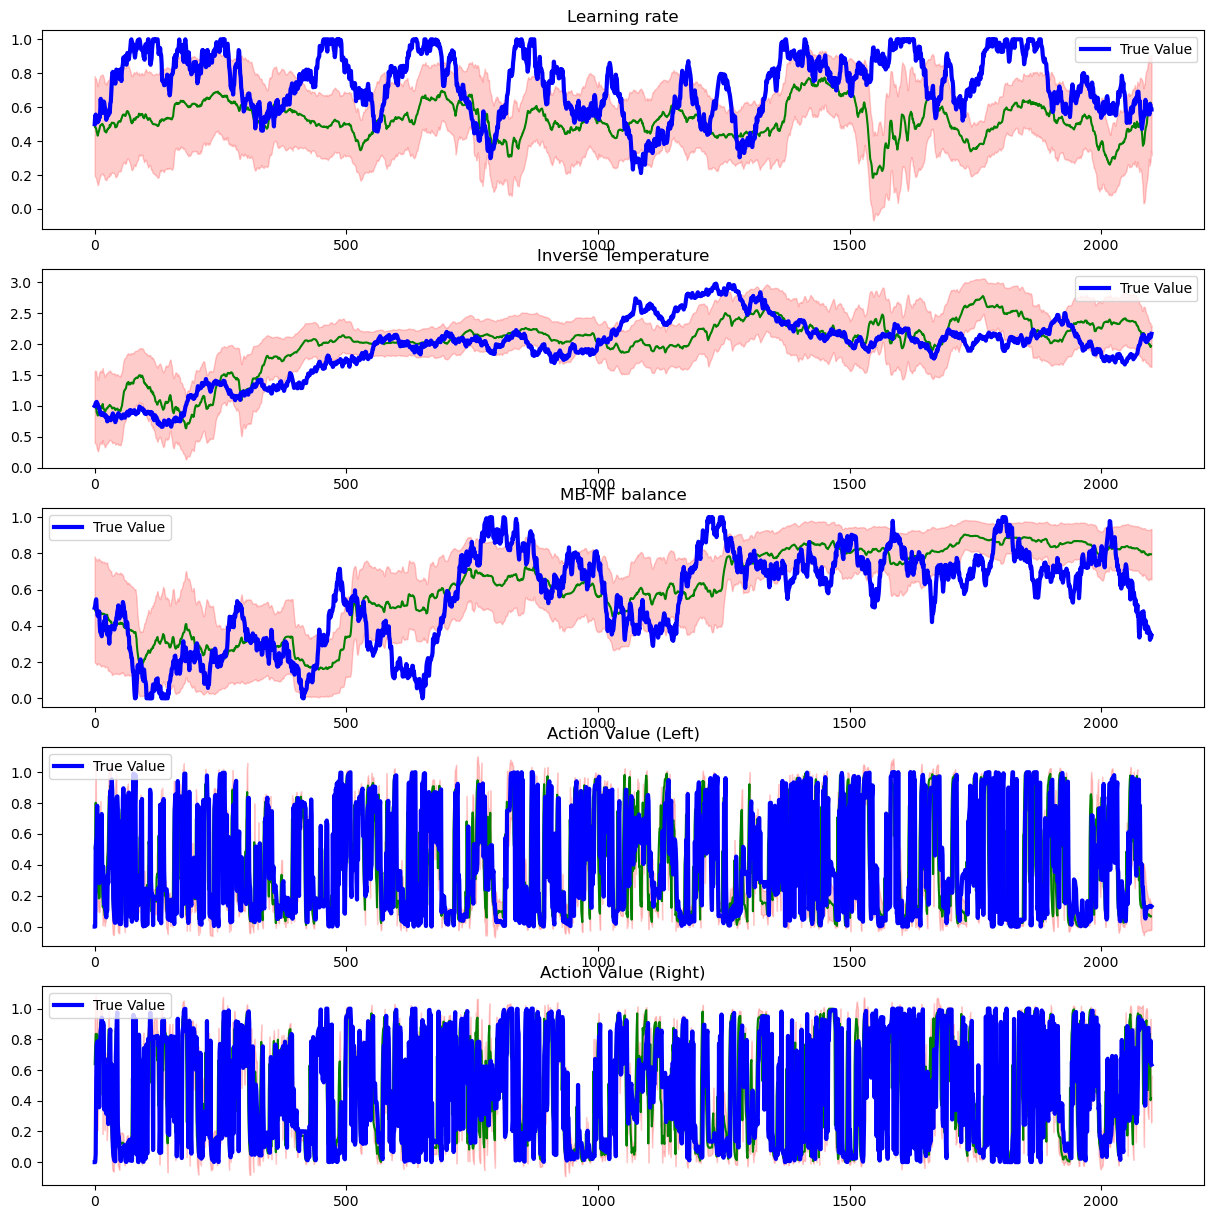

In [2197]:
plt.subplots(figsize = (15,15))
plt.subplot(5,1,1)
mean_ = np.squeeze(result[6][4])[:,8]
std_ = np.squeeze(result[6][5])[:,8]
plt.plot(np.squeeze(result[6][4])[:,8], c = 'g')
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['alpha1'], 'b',  linewidth = 3, label="True Value")
plt.title('Learning rate')
plt.legend()

plt.subplot(5,1,2)
mean_ = np.squeeze(result[6][4])[:,9]
std_ = np.squeeze(result[6][5])[:,9]
plt.plot(np.squeeze(result[6][4])[:,9], c = 'g')
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['beta'], 'b',  linewidth = 3, label="True Value")
plt.title('Inverse Temperature')
plt.legend()

plt.subplot(5,1,3)
mean_ = np.squeeze(result[6][4])[:,10]
std_ = np.squeeze(result[6][5])[:,10]
plt.plot(np.squeeze(result[6][4])[:,10], c = 'g')
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['epsilon'], 'b',  linewidth = 3, label="True Value")
plt.title('MB-MF balance')
plt.legend()

plt.subplot(5,1,4)
mean_ = np.squeeze(result[6][4])[:,0]
std_ = np.squeeze(result[6][5])[:,0]
plt.plot(np.squeeze(result[6][4])[:,0], c = 'g')
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QR'], 'b',  linewidth = 3, label="True Value")
plt.title('Action Value (Left)')
plt.legend()

plt.subplot(5,1,5)
mean_ = np.squeeze(result[6][4])[:,1]
std_ = np.squeeze(result[6][5])[:,1]
plt.plot(np.squeeze(result[6][4])[:,1], c = 'g')
plt.fill_between(np.linspace(0,lens,lens), mean_ - std_, mean_ + std_, color = 'r', alpha = 0.2)
plt.plot(np.linspace(0,lens,lens),A['QL'], 'b',  linewidth = 3, label="True Value")
plt.title('Action Value (Right)')
plt.legend()

In [2198]:
alldata['parameter']

{0: {'alpha1': 0.01, 'beta': 0.01, 'epsilon': 0.01},
 1: {'alpha1': 0.01, 'beta': 0.01, 'epsilon': 0.011},
 2: {'alpha1': 0.01, 'beta': 0.011, 'epsilon': 0.01},
 3: {'alpha1': 0.01, 'beta': 0.011, 'epsilon': 0.011},
 4: {'alpha1': 0.011, 'beta': 0.01, 'epsilon': 0.01},
 5: {'alpha1': 0.011, 'beta': 0.01, 'epsilon': 0.011},
 6: {'alpha1': 0.011, 'beta': 0.011, 'epsilon': 0.01},
 7: {'alpha1': 0.011, 'beta': 0.011, 'epsilon': 0.011}}